# Neural Networks

In this notebook you will learn how to implement the perceptron and a sigmoid unit in Python and how to use PyTorch to
implement the Multilayer perceptron (MLP).

## The Perceptron and Sigmoid Unit

In this section we will be working with the perceptron. This is not commonly used in
practice but understanding its inner working will help you understand more complicated neural network architectures.

To test this algorithm we will use a simulated dataset.

## The Dataset

To generate the dataset we will start from a bi-variate normal distribution with mean $(0, 0)$ and
variance $I_2$. We will now sample 1000 examples. Note that before doing that we create a numpy
array of size (n, 3) filled with 1s. This is done in order to avoid the bias term in the perceptron later and
make the algorithm simpler.

In [1]:
import numpy as np

# number of examples to generate
n = 1000
# create an array of ones of size n x 3
xs = np.ones((n, 3))
# use a bi-variate normal distribution to generate the examples
xs[:, 1:] = np.random.multivariate_normal(mean = [0, 0], cov=np.eye(2), size = n)

xs

array([[ 1.        ,  0.0450163 ,  0.97642758],
       [ 1.        , -0.62457736, -0.77119616],
       [ 1.        ,  0.24889391, -1.40038501],
       ...,
       [ 1.        , -0.32615134,  1.16154849],
       [ 1.        , -1.03824134,  0.25678951],
       [ 1.        ,  1.24993788,  0.12591887]])

Let's now plot this bi-dimensional dataset to see how it looks like.

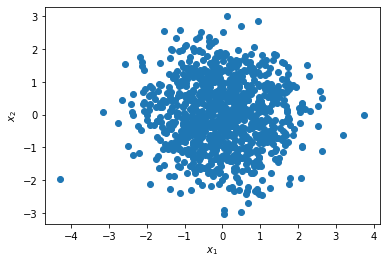

In [3]:
import matplotlib.pyplot as plt

plt.scatter(xs[:,1], xs[:,2])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

To generate a binary target function we will first generate a random hyperplane and use that with the previously
generated data to separate it into two classes.

\begin{equation}
w_0 + w_1 x_1 + w_2 x_2 > 0,\quad w_0 + w_1 x_1 + w_2 x_2 \leq 0
\end{equation}

When this returns a positive value we will assign 1, when this returns a negative value with zero included we will
assign -1.

In [4]:
ws = np.random.random(3)

ws

array([0.5132154 , 0.69685757, 0.10367953])

To generate the target value we perform the following transformation:

In [5]:
ys = 2 * (ws @ xs.transpose() > 0) - 1

# we print the first 10 results
ys[:10]

array([ 1, -1,  1,  1,  1,  1,  1, -1,  1,  1])

We can now inspect this target function.

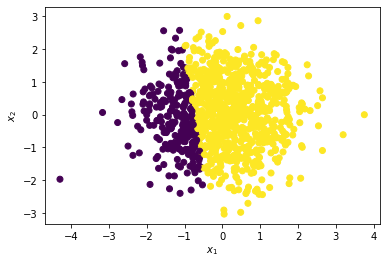

In [8]:
plt.scatter(xs[:,1], xs[:,2], c=ys)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

We have now generated a linearly separable dataset.

## The Perceptron

Now we implement in Python the perceptron.

In [16]:
class Perceptron:

    def __init__(self, input_size=3):
        # initialize weights to a small random value
        self.ws = np.random.random(input_size)/10

    def classify(self, x):
        return 2 * (self.ws @ x > 0) - 1

We now instantiate a perceptron with an input size of 3 and test it using the first example of the previously generated
dataset.

In [17]:
pr_clf = Perceptron(3)

pr_clf.classify(xs[0, :])

1

To train this we need to implement the update rule for the Perceptron.

But first let's test this randomly initialized perceptron by evaluating its accuracy.

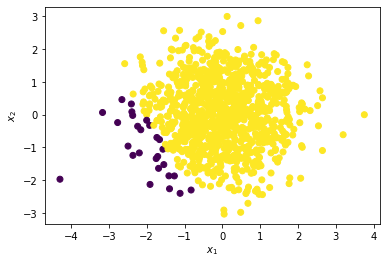

Accuracy of a randomly initialized Perceptron 0.788


In [18]:
def accuracy(ys, hat_ys):
    return np.mean(ys == hat_ys)

hat_ys = pr_clf.classify(xs.transpose())

plt.scatter(xs[:, 1], xs[:, 2], c=hat_ys)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

print('Accuracy of a randomly initialized Perceptron', accuracy(ys, hat_ys))

We will now first develop the Mean Squared Error (MSE) function, which will be used as a loss function.

In [19]:
def mean_squared_error(ys, hat_ys):
    return np.mean((ys - hat_ys)**2)

print('MSE of a randomly initialized Perceptron', mean_squared_error(ys, hat_ys))

MSE of a randomly initialized Perceptron 0.848


Then we develop the gradient descent algorithm for the Perceptron.

Text(0.5, 0, 'epoch')

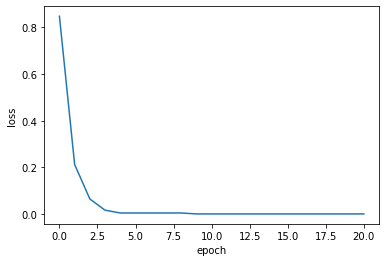

In [20]:
def gradient_descent_for_perceptron(model, xs, ys, eta=0.00005, epochs=20):
    # this part is used to log the training error
    hat_ys = model.classify(xs.transpose()) # compute prediction
    error = mean_squared_error(ys, hat_ys)
    train_error = [error]

    # this is the training loop
    for _ in range(epochs): # termination condition
        delta_ws = np.zeros(xs.shape[1]) # initialize delta weights to zero
        # for example we compute accumulate the gradient
        for x, y in zip(xs, ys):
            hat_y = model.classify(x)
            delta_ws += eta * (y - hat_y) * x
        # we update the weights of the perceptron
        model.ws = model.ws + delta_ws

        # compute its error for logging purposes
        hat_ys = model.classify(xs.transpose()) # compute model
        error = mean_squared_error(ys, hat_ys)
        train_error.append(error)

    return train_error

train_error = gradient_descent_for_perceptron(pr_clf, xs, ys, eta=0.00005, epochs=20)

plt.plot(train_error)
plt.ylabel('loss')
plt.xlabel('epoch')

In the figure above we see the training curve of the perceptron. We can see that at each epoch the
perceptron makes fewer mistakes, until it converged to 0. Try to play with the learning rate ($\eta$)
and the number of epochs to see how this curve changes. For example test what happens when the learning rate
is much larger.

If we now evaluate the trained Perceptron we should obtain a perfect classification (accuracy equal to 1).

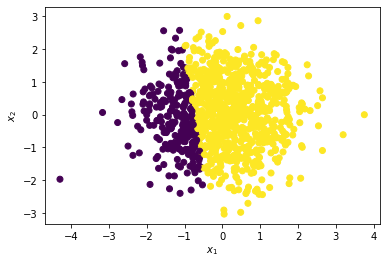

Accuracy of the trained Perceptron 1.0


In [21]:
hat_ys = pr_clf.classify(xs.transpose())

plt.scatter(xs[:, 1], xs[:, 2], c=hat_ys)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

print('Accuracy of the trained Perceptron', accuracy(ys, hat_ys))

## Training a Sigmoid Unit

In order to implement the Sigmoid unit we first need to define the sigmoid function.
This a special version of the sigmoid function because it works with vectors.

In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

print('original vector\t\t\t', xs[0, :])
print('after applying the sigmoid\t', sigmoid(xs[0, :]))

original vector			 [1.         0.0450163  0.97642758]
after applying the sigmoid	 [0.73105858 0.51125217 0.72639879]


In [31]:
class SigmoidUnit:

    def __init__(self, input_size=3):
        # initialize weights to a small random value
        self.ws = np.random.random(input_size)/10

    def classify(self, x):
        return  sigmoid(self.ws @ x)

We now instantiate the Sigmoid unit with an input size of 3 and test it using the first example of the previously generated
dataset.

In [76]:
su_clf = SigmoidUnit(3)

su_clf.classify(xs[0, :])

0.5269825236555671

Please notice that the Sigmoid unit returns a value between 0 and 1. This has implications on the label that we need to
provide when training and on its output that needs to be binarized by setting a thresholt.

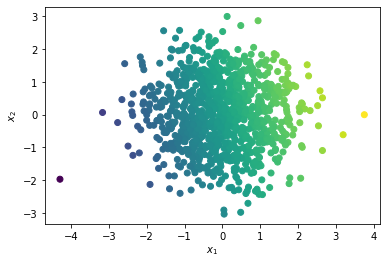

In [77]:
hat_ys = su_clf.classify(xs.transpose())

plt.scatter(xs[:, 1], xs[:, 2], c=hat_ys)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

We now set the threshold to 0.5.

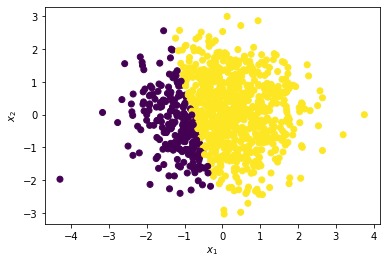

Accuracy of a randomly initialized Perceptron 0.75


In [78]:
hat_ys = su_clf.classify(xs.transpose()) > 0.5

plt.scatter(xs[:, 1], xs[:, 2], c=hat_ys)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

print('Accuracy of a randomly initialized Perceptron', accuracy(ys, hat_ys))

To train this we need to implement the update rule for the Sigmoid unit.

Text(0.5, 0, 'epoch')

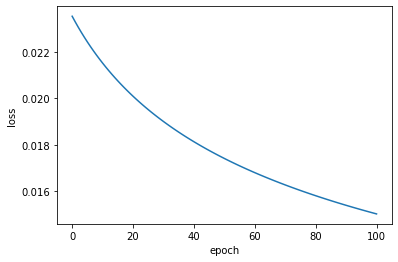

In [84]:
def gradient_descent_for_sigmoid_unit(model, xs, ys, eta=0.00005, epochs=20):
    # this part is used to log the training error
    hat_ys = model.classify(xs.transpose()) # compute prediction
    error = mean_squared_error(ys, hat_ys)
    train_error = [error]

    # this is the training loop
    for _ in range(epochs): # termination condition
        delta_ws = np.zeros(xs.shape[1]) # initialize delta weights to zero
        # for example we compute accumulate the gradient
        for x, y in zip(xs, ys):
            hat_y = model.classify(x)
            delta_ws += eta * hat_y * (1 - hat_y) * (y - hat_y) * x
        # we update the weights of the perceptron
        model.ws = model.ws + delta_ws

        # compute its error for logging purposes
        hat_ys = model.classify(xs.transpose()) # compute model
        error = mean_squared_error(ys, hat_ys)
        train_error.append(error)

    return train_error

ys_for_su = ys > 0
train_error = gradient_descent_for_sigmoid_unit(su_clf, xs, ys_for_su, eta=0.05, epochs=100)

plt.plot(train_error)
plt.ylabel('loss')
plt.xlabel('epoch')

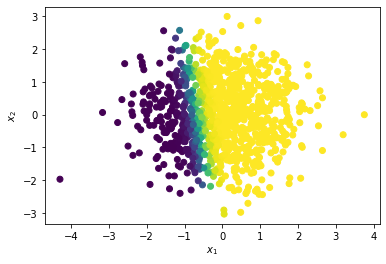

In [85]:
hat_ys = su_clf.classify(xs.transpose())

plt.scatter(xs[:, 1], xs[:, 2], c=hat_ys)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [86]:
hat_ys = su_clf.classify(xs.transpose()) > 0.5
print('Accuracy of the trained Sigmoid', accuracy(ys_for_su, hat_ys))

Accuracy of the trained Sigmoid 0.997


## Neural Networks in PyTorch

PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer
vision and natural language processing, primarily developed by Facebook's AI Research lab.

PyTorch is a scientific computing package serving two broad purposes:
* A replacement for NumPy to use the power of GPUs and other accelerators.
* An automatic differentiation library that is useful to implement neural networks.

To correctly install PyTorch, please follow this [link](https://pytorch.org/).

## The MNIST Dataset

The MNIST dataset is a large database of handwritten digits.
The MNIST database contains 60,000 training images and 10,000 testing images.
The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker.

In [87]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# download train and test sets
dataset_train = datasets.MNIST(root = './data', train = True, transform = transforms.ToTensor(), download = True)
dataset_validation = datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

print("Number of examples in the training set:", dataset_train)
print("Number of examples in the validation set:", dataset_validation)

Number of examples in the training set: Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Number of examples in the validation set: Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


Let's start by visualising the first batch of examples.

/Users/ucaclip/opt/anaconda3/envs/CEGE0004/lib/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/ucaclip/opt/anaconda3/envs/CEGE0004/lib/python3.8/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


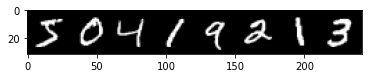

tensor([5, 0, 4, 1, 9, 2, 1, 3])


In [88]:
from torchvision.utils import make_grid

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get the first 8 training images
images = dataset_train.train_data[:8].reshape(-1, 1, 28, 28)
labels = dataset_train.train_labels[:8]

# show images
imshow(make_grid(images))
# print labels
print(labels)

Let's now print some statistics about the images above and the dataset.

In [89]:
print('Shape of the input:', images.shape)
print('Shape of the output:', labels.shape)
print('Number of classes:', len(dataset_train.classes))
print('Classes:', dataset_train.classes)

Shape of the input: torch.Size([8, 1, 28, 28])
Shape of the output: torch.Size([8])
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


PyTorch implements a way to handle training data using the DataLoader class. We will use this in order to
iterate across the training and validation sets. The batch size is the number of examples we will provide to the model
at every iteration. This usually corresponds to the batch size of GD.

In [90]:
import torch
from torch.utils.data import DataLoader

batch_size = 5

# use the dataloader helper to generate an iterator for the train set to return random examples 5 by 5 (train batch size).
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)

# use the dataloader helper to generate an iterator for the test set to return examples 100 by 100.
validation_loader = DataLoader(dataset_validation, batch_size=100, shuffle=False, num_workers=2)

## Multi-Layer Perceptron in PyTorch

The task you will solve is: given a handwritten digit, from 0 to 9, recognize and output its digit.

This task is not a task for binary classifiers because the output required by the classifier is not binary but decimal.
This will require the definition of a so called multi-way classifier, a 10-way classifier in this case.
You can think of a 10-way classifier as 10 independent binary classifiers, one for each digit, which all at the same
time output a prediction about the probability of having recognized a digit or not.
Then, take the most confident classifier as the correct answer.

We will now define and train a Multi-Layer Perceptron. In PyTorch you can do this in two ways:
* the easy but limited way, or;
* the hard but flexible way.

Let's start with the hard way. Here you need to create a class with a constructor used to define the components of
the neural network, and a forward method used to combine the parts of the network together. This computes also the
forward step of the network. There is no need to define the backward step used for training because fully handled by
PyTorch.

In [92]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):

  def __init__(self, input_size, hidden_sizes, output_size):
    super(MLP, self).__init__()
    self.layers = nn.ModuleList() # list of layers
    next_hidden_size = input_size # input size of the first layer, this depends on the dataset
    for hidden_size in hidden_sizes: # for loop to define the next hidden layers
      self.layers.append(nn.Linear(next_hidden_size, hidden_size))
      next_hidden_size = hidden_size
    self.output = nn.Linear(next_hidden_size, output_size) # output layer

  def forward(self, x): # defines the forward pass
    out = x
    for layer in self.layers:
        out = layer(out)
        out = F.relu(out) # activation function
    out = self.output(out)
    return out


Now you can instantiate this model.

In [93]:
model = MLP(28*28, [400, 400, 10], 10)

print("Print the structure of the model:")
model

Print the structure of the model:


MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=10, bias=True)
  )
  (output): Linear(in_features=10, out_features=10, bias=True)
)

We will now define the same module in the easy way. Here you just need to use components of PyTorch to construct the
network by stacking elements on top of each other using the Sequential class.

In [94]:
model = nn.Sequential(
    nn.Linear(28*28, 400), # input layer
    nn.ReLU(), # activation function
    nn.Linear(400, 400), # first hidden layer
    nn.ReLU(), # activation function
    nn.Linear(400, 400), # second hidden layer
    nn.ReLU(), # activation function
    nn.Linear(400, 10)) # output layer

print("Print the structure of the model:")
model

Print the structure of the model:


Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=400, bias=True)
  (5): ReLU()
  (6): Linear(in_features=400, out_features=10, bias=True)
)

Now that we have a model, we can select the optimizer. For this exercise we use Stochastic Gradient Descent (SGD).
To do this we need to pass which parameters of our model need to be optimized, a learning rate and a momentum.

In [96]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)


For an MLP in a multi-way classification setting a good loss is the cross entropy.
In the next code cell we will define this loss.

In [97]:
criterium = nn.CrossEntropyLoss()

We will now define the training loop.

But first let's define a helper function used to compute the loss of the model on the validation set while training.

In [98]:
def compute_loss_validation(model):
    tot_loss = 0
    batch_size = validation_loader.batch_size
    for i, batch in enumerate(validation_loader):
        images, labels = batch
        xs = images.view(-1, 28*28)
        ys = labels

        pred_ys = model(xs) # generate the predictions using the model
        loss = criterium(pred_ys, ys) # evaluate the predictions using the cross entropy loss
        tot_loss += loss.item() # get the number and sum it to the total loss

        if (i+1) % batch_size == 0:
            break

    loss = tot_loss / batch_size # normalize the loss based on the number of testing examples
    return loss

Let's now set the number of times the model will be trained on the entire training set.

In [100]:
epochs = 10 # how many times you want to train on the dataset

Now you will first set the model to training mode. This means that the provided examples will be used for training.
Then, the model will loop over two for loops, one over the epochs and one over the batches.

In [101]:
model.train() # set the model to training mode

# these variables are used to store the losses
running_loss = 0
training_loss = []
validating_loss = []
# loop over the epochs
for epoch in range(epochs):
  # loop over the batches
  for i, batch in enumerate(train_loader):
    images, labels = batch # extract images and labels
    xs = images.view(-1, 28*28) # flatten the image into a vector
    ys = labels

    optimizer.zero_grad() # reset the gradients
    pred_ys = model(xs) # generate the predictions
    loss = criterium(pred_ys, ys) # compute the loss
    loss.backward() # backpropagation
    optimizer.step() # optmizes here

    running_loss += loss.item()
    if (i+1) % 200 == 0: # every 100 batches print statistics about the training
      running_loss /= 200 # training loss on the last batch
      training_loss.append(running_loss) # keep track of the training loss
      model.eval() # set the model to eval, we can now test the model
      validation_loss = compute_loss_validation(model) # compute the validation loss
      validating_loss.append(validation_loss) # keep track of the validation loss
      model.train() # set back the model to train
      print('Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f, Validation Loss: %.4f'%(
          epoch+1,
          epochs,
          i+1,
          len(dataset_train)//batch_size, running_loss, validation_loss))
      running_loss = 0


Epoch [1/10], Step [200/12000], Train Loss: 2.2422, Validation Loss: 2.0481
Epoch [1/10], Step [400/12000], Train Loss: 1.2500, Validation Loss: 1.0527
Epoch [1/10], Step [600/12000], Train Loss: 0.7191, Validation Loss: 0.5776
Epoch [1/10], Step [800/12000], Train Loss: 0.5891, Validation Loss: 0.5418
Epoch [1/10], Step [1000/12000], Train Loss: 0.5252, Validation Loss: 0.4671
Epoch [1/10], Step [1200/12000], Train Loss: 0.5098, Validation Loss: 0.3908
Epoch [1/10], Step [1400/12000], Train Loss: 0.4143, Validation Loss: 0.3390
Epoch [1/10], Step [1600/12000], Train Loss: 0.3690, Validation Loss: 0.3304
Epoch [1/10], Step [1800/12000], Train Loss: 0.3757, Validation Loss: 0.3260
Epoch [1/10], Step [2000/12000], Train Loss: 0.3491, Validation Loss: 0.3281
Epoch [1/10], Step [2200/12000], Train Loss: 0.4335, Validation Loss: 0.2929
Epoch [1/10], Step [2400/12000], Train Loss: 0.3303, Validation Loss: 0.3116
Epoch [1/10], Step [2600/12000], Train Loss: 0.2708, Validation Loss: 0.3001
Epo

You can now plot the train and validation losses. However, in order to get a better plot we need to shift the
training loss by one. This because, although the training loss and validation losses are computed over 200 batches,
the training loss is used to improve the model. This means that its loss decreases across the batches, while
the validation loss does not, because computed with the current best model. Hence, the validation loss may
become lower than the training loss. To avoid this artifact, we shift the validation loss by one forward.

In [102]:
training_loss.pop()
validating_loss.insert(0, float('NaN'))

We now plot these losses.

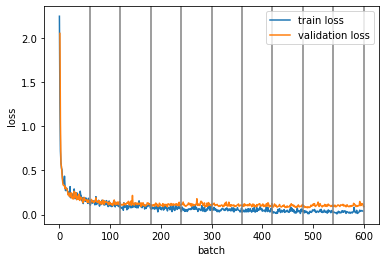

In [103]:
plt.plot(training_loss, label="train loss")
plt.plot(validating_loss, label="validation loss")
plt.legend(loc='upper right')

for i in range(epochs):
    plt.axvline(x=(len(dataset_train)//batch_size)*(i+1)/200,color='gray')

plt.ylabel('loss');
plt.xlabel('batch')
plt.show()

You can evaluate this classifier using Accuracy. This is defined in the following code cell.

In [104]:
def accuracy(data_loader):
    correct = 0.0 # here you will count the correct answers
    total = 0.0 # here you will count all the answers
    with torch.no_grad(): # ingnore the gradient graph
        for batch in data_loader:
            images, labels = batch
            xs = images.view((-1, 28*28))
            ys = labels

            hat_ys = model(xs).detach().cpu()
            _, hat_ys = torch.max(hat_ys, 1)
            correct += (hat_ys == ys).sum()
            total += labels.size(0)

    return correct/total

You can now compute the accuracy of the model on the train and validation sets.

In [105]:
model.eval() # set the model to evaluation

train_accuracy = accuracy(train_loader)
print('Train accuracy of the MLP {:.3f}'.format(train_accuracy))

validation_accuracy = accuracy(validation_loader)
print('Validation accuracy of the MLP {:.3f}'.format(validation_accuracy))

Train accuracy of the MLP 0.992
Validation accuracy of the MLP 0.980
